# Super-resolución 2x:
## Restauración del modelo y generación de imágenes:

Ejercicio de curso para la asignatura de Computación Inteligente perteneciente al Máster Universitario en Sistemas Inteligentes y Aplicaciones Numéricas para la Ingeniería (MUSIANI) en el curso 2020/21, realizado por Juan Sebastián Ramírez Artiles.

En este notebook se cargará el modelo generado en el notebook [SR_Faces_Model.ipynb](SR_Faces_Model.ipynb) y se usará para procesar las 100 imágenes del conjunto de validación. El resultado final se puede observar al final del documento.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from pathlib import Path
from os.path import join
import torch.nn.functional as nnf
from os import listdir
from PIL import Image

In [2]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size = 7, padding = 3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 7, padding = 3)
        self.conv3 = nn.Conv2d(16, 8, kernel_size = 7, padding = 3)
        self.conv4 = nn.Conv2d(8, 1, kernel_size = 7, padding = 3)
        
        self.upsample = nn.Upsample(scale_factor = 2)

    def forward(self, xb):
        
        xb = self.upsample(xb)
        xb = torch.tanh(self.conv1(xb))
        xb = torch.tanh(self.conv2(xb))
        xb = torch.tanh(self.conv3(xb))
        
        return torch.tanh(self.conv4(xb))

In [3]:
model = torch.load("SR_model_Faces_2.0.ml")
model.eval()

SuperResolution(
  (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv4): Conv2d(8, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (upsample): Upsample(scale_factor=2.0, mode=nearest)
)

In [4]:
bs = 16
ngpu = 1
output_path = "output/SR_faces_upsample_4x"

Path(output_path).mkdir(parents=True, exist_ok=True)

path_valid_x = "faces/valid_x/x8"

In [5]:
class FacesDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        
        self.x_files = listdir(root_dir)
        self.dir_x = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
                
        img_x = Image.open(join(self.dir_x, self.x_files[idx]))
        
        if self.transform:
            img_x = self.transform(img_x)

        return img_x

In [6]:
class Pil2YCbCr(object):
    def __call__(self, img):
        return img.convert('YCbCr')

In [7]:
def denormalize_Gauss(img):
    mean = torch.Tensor([0.5])
    std = 0.5
    
    return img * std + mean.expand_as(img)

In [8]:
transform = transforms.Compose([
    Pil2YCbCr(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imgs_valid = FacesDataset(path_valid_x, transform = transform)

In [9]:
imgs_valid_dl = DataLoader(imgs_valid, batch_size = bs, shuffle = True)

In [10]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [11]:
def save_images(i, pred_sr):
    for j, img in enumerate(pred_sr):
        filename = str(bs*i + j+1).zfill(5) + ".png"
        img.save(join(output_path, filename))

In [12]:
model = model.to(device)

In [13]:
i = 0
for xb in imgs_valid_dl:
    
    Y_channel = xb[:,0].unsqueeze(-3)
    Cb = xb[:,1].unsqueeze(-3)
    Cr = xb[:,2].unsqueeze(-3)
    
    Y_channel = Y_channel.to(device)
    Y_sr = model(Y_channel)
    
    Cb = nnf.interpolate(Cb, scale_factor = 2, mode = 'bicubic')
    Cr = nnf.interpolate(Cr, scale_factor = 2, mode = 'bicubic')
    
    imgs_sr = torch.cat((Y_sr.cpu(), Cb, Cr), 1)
    imgs_sr = denormalize_Gauss(imgs_sr)
    
    tr = transforms.ToPILImage('YCbCr')
    
    pil_imgs_sr = [tr(img) for img in imgs_sr]
    pil_imgs_sr = [img.convert('RGB') for img in pil_imgs_sr]
    
    save_images(i, pil_imgs_sr)
    i += 1    

C:\Anaconda3\.conda\envs'\torch_env\lib\site-packages\torch\nn\functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

pred_imgs_fd = FacesDataset(output_path, transform = transform)
pred_imgs_dl = DataLoader(pred_imgs_fd, batch_size = 8)
iter_pred_imgs = iter(pred_imgs_dl)
imgs = iter_pred_imgs.next()

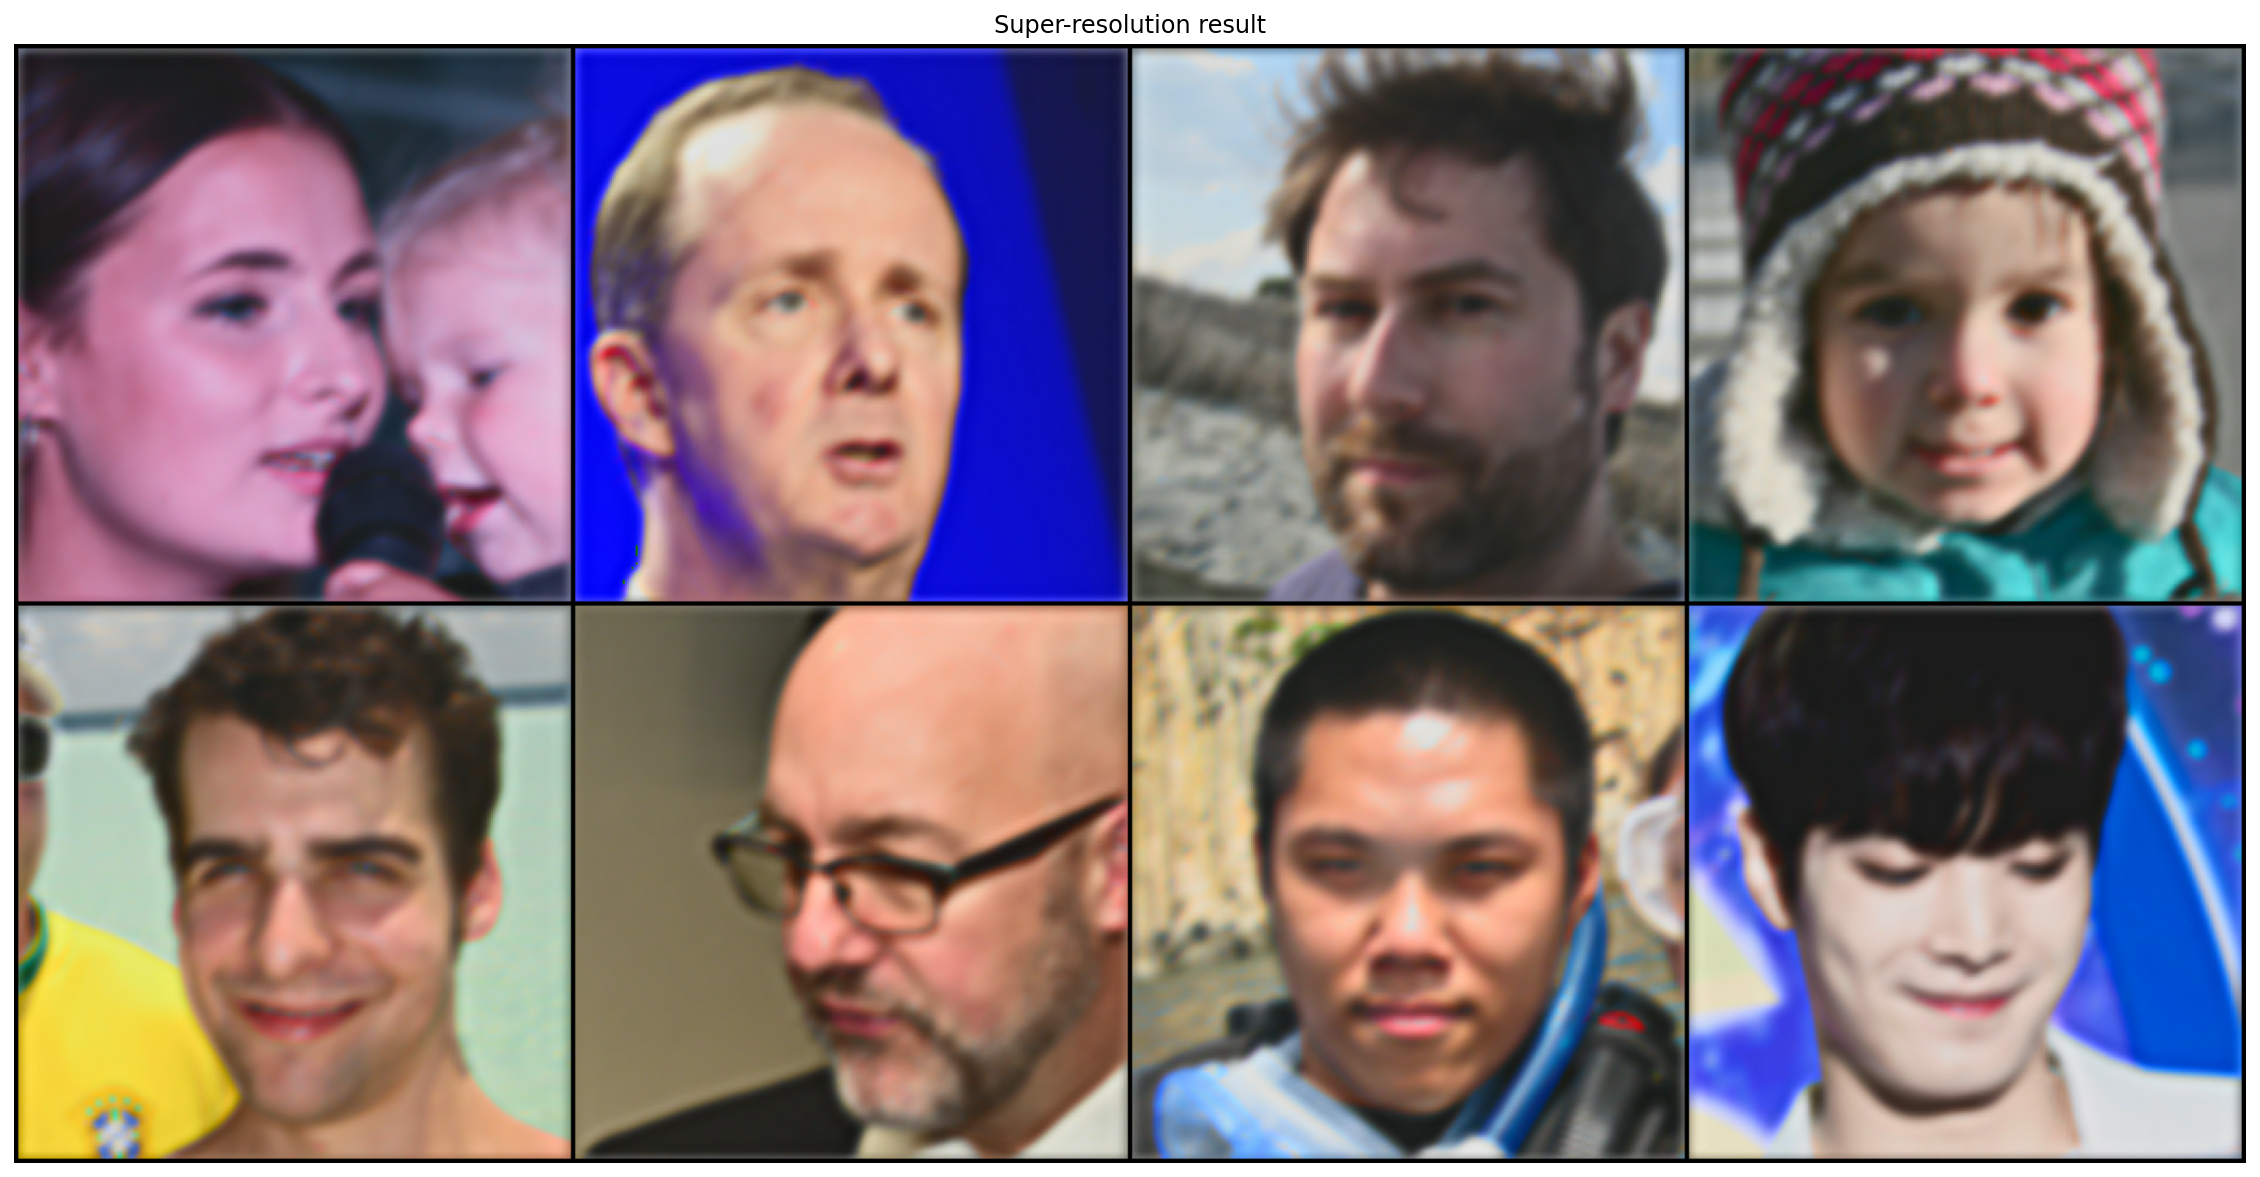

In [15]:
grid_img = vutils.make_grid(imgs, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Super-resolution result")
plt.imshow(grid_img.permute(1, 2, 0))
#plt.imshow(grid_img)

In [16]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>